<a href="https://colab.research.google.com/github/rajlm10/D2L-Torch/blob/main/D2L_Matrix_Factorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q d2l torchinfo

     |████████████████████████████████| 82 kB 766 kB/s 
     |████████████████████████████████| 15.7 MB 20.1 MB/s 
     |████████████████████████████████| 61 kB 9.2 MB/s 
     |████████████████████████████████| 9.9 MB 52.3 MB/s 
     |████████████████████████████████| 11.2 MB 48.9 MB/s 
     |████████████████████████████████| 930 kB 65.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.25.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
from tqdm import tqdm
import math

In [ ]:
d2l.DATA_HUB['ml-100k'] = (
    'https://files.grouplens.org/datasets/movielens/ml-100k.zip',
    'cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')

def read_data_ml100k():
    data_dir = d2l.download_extract('ml-100k')
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), '\t', names=names,engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

In [ ]:
data, num_users, num_items = read_data_ml100k()
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')

number of users: 943, number of items: 1682
matrix sparsity: 0.936953


In [ ]:
data.head(5)

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [ ]:
#Note that user_id and item_id start with 1
data.describe()

,user_id,item_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


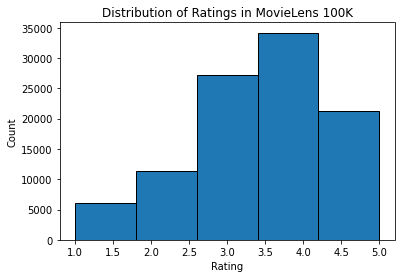

In [ ]:
d2l.plt.hist(data['rating'], bins=5, ec='black')
d2l.plt.xlabel('Rating')
d2l.plt.ylabel('Count')
d2l.plt.title('Distribution of Ratings in MovieLens 100K')
d2l.plt.show()

# Splitting the data

We split the dataset into training and test sets. The following function provides two split modes including random and seq-aware. In the random mode, the function splits the 100k interactions randomly without considering timestamp and uses the 90% of the data as training samples and the rest 10% as test samples by default. In the seq-aware mode, we leave out the item that a user rated most recently for test, and users’ historical interactions as training set. User historical interactions are sorted from oldest to newest based on timestamp. This mode will be used in the sequence-aware recommendation section.

In [ ]:
#We have atleast 96 entries per user
#If we had 1 entry only, we can't use it in the test set and hence can omit that user
min(data.groupby('user_id')['user_id'].sum()) 

96

In [ ]:
def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    columns= list(data.columns)
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in tqdm(data.to_dict('records')):
            u, i, rating, time = line['user_id'], line['item_id'], line['rating'], line['timestamp']
            #key-> user_id value-> all instances of u
            train_items.setdefault(u, []).append((u, i, rating, time))
            #for every unique u make an entry and if u already exists
            # replace the entry by most recent entry for u
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            #list of tuples
            train_list.extend(sorted(train_items[u], key=lambda k: k[-1]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data,columns=columns)
        test_data = pd.DataFrame(test_data,columns=columns)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

# Load Data

After dataset splitting, we will convert the training set and test set into lists and dictionaries/matrix for the sake of convenience. The following function reads the dataframe line by line and enumerates the index of users/items start from zero. The function then returns lists of users, items, ratings and a dictionary/matrix that records the interactions. We can specify the type of feedback to either explicit or implicit

In [ ]:
def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in tqdm(data.to_dict('records')):
        #subtract 1 since user_id & item_id start from 1
        user_index, item_index = int(line['user_id'] - 1), int(line['item_id'] - 1)
        score = int(line['rating']) if feedback == 'explicit' else 1
        users.append(user_index) #len num interactions
        items.append(item_index) #len num interactions
        scores.append(score)     #len num interactions
        if feedback == 'implicit':
            #for each user, list of items interacted with
            inter.setdefault(user_index, []).append(item_index)
        else:
            #num_items x num_users matrix with interaction scores at each position
            inter[item_index, user_index] = score
    return users, items, scores, inter

In [ ]:
def create_iterator(dataset,batch_size,is_train=True):
  dataset=torch.utils.data.TensorDataset(*dataset)
  return torch.utils.data.DataLoader(dataset,batch_size,shuffle=is_train)

In [ ]:
def split_and_load_ml100k(split_mode='seq-aware', feedback='explicit',test_ratio=0.1, batch_size=256):
    data, num_users, num_items = read_data_ml100k()
    train_data, test_data = split_data_ml100k(
        data, num_users, num_items, split_mode, test_ratio)
    train_u, train_i, train_r, _ = load_data_ml100k(
        train_data, num_users, num_items, feedback)
    test_u, test_i, test_r, _ = load_data_ml100k(
        test_data, num_users, num_items, feedback)
    
    train_u, train_i, train_r = torch.tensor(train_u,dtype=torch.long),torch.tensor(train_i,dtype=torch.long),torch.tensor(train_r,dtype=torch.float32)
    test_u, test_i, test_r = torch.tensor(test_u,dtype=torch.long),torch.tensor(test_u,dtype=torch.long),torch.tensor(test_r,dtype=torch.float32)    

    train_iter= create_iterator ((train_u, train_i, train_r),batch_size=batch_size,is_train=True)
    
    test_iter= create_iterator ((test_u, test_i, test_r),batch_size=batch_size,is_train=False)
    return num_users,num_items,train_iter, test_iter

In [ ]:
num_users, num_items, train_iter, test_iter= split_and_load_ml100k(split_mode='seq-aware', feedback='explicit',test_ratio=0.1, batch_size=256)

100%|██████████| 943/943 [00:00<00:00, 354157.30it/s]


In [ ]:
for batch in train_iter:
  print(len(batch))
  print(batch[0].shape)
  print(batch[1].shape)
  print(batch[2].shape)
  break

3
torch.Size([256])
torch.Size([256])
torch.Size([256])


# Buikding the Model

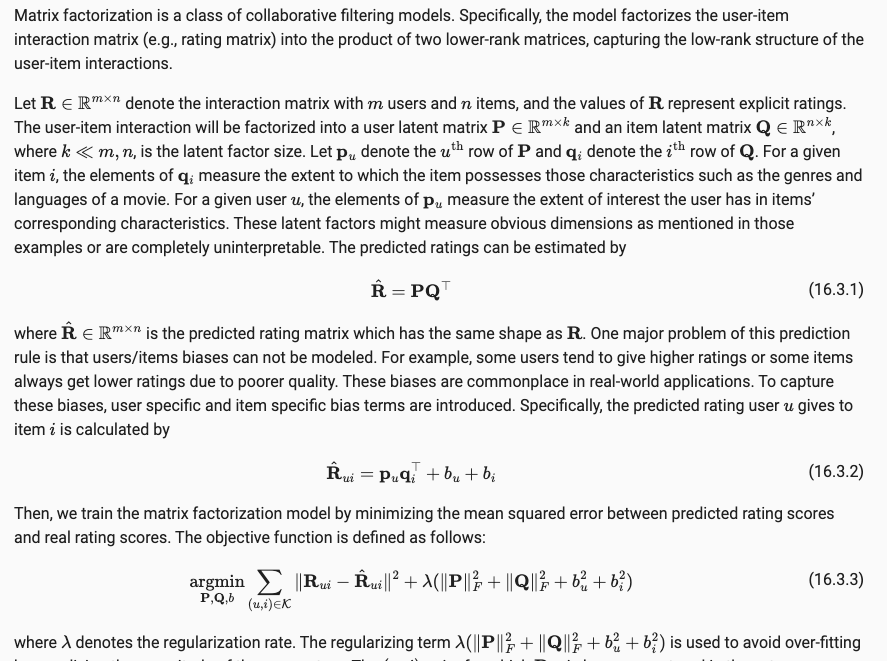

In [ ]:
class MatrixFactorization(nn.Module):
  def __init__(self, num_factors, num_users, num_items, **kwargs):
    super(MatrixFactorization,self).__init__(**kwargs)
    self.P = nn.Embedding(num_users,num_factors)
    self.Q = nn.Embedding(num_items,num_factors)
    self.user_bias = nn.Embedding(num_users,1)
    self.item_bias = nn.Embedding(num_items,1)
  
  def forward(self,user_id,item_id):
    P_u = self.P(user_id) #batch_size,num_factors
    Q_i = self.Q(item_id) #batch_size,num_factors
    b_u = self.user_bias(user_id) #batch_size,1
    b_i = self.item_bias(item_id) #batch_size,1

    R = (P_u*Q_i).sum(axis=1) + b_u.view(-1) + b_i.view(-1)
    return R.flatten()


In [ ]:
def init_weights(m):
  if type(m) == nn.Embedding:
    nn.init.xavier_normal_(m.weight,0.01) 


In [ ]:
def evaluate_rmse_gpu(net, data_iter, device=None):
  if isinstance(net, nn.Module):
    net.eval() # Set the model to evaluation mode 
    if not device:
      device = next(iter(net.parameters())).device 

  # No. of correct predictions, no. of predictions 
  metric = d2l.Accumulator(2)
  with torch.no_grad():
    for user_ids,label_ids, y in data_iter:
      user_ids = user_ids.to(device)
      label_ids = label_ids.to(device)
      y = y.to(device) 
      metric.add(nn.MSELoss(reduction='sum')(net(user_ids,label_ids),y), y.shape[0])
  return math.sqrt(metric[0] / metric[1])

In [ ]:
def train_batch(net,X,y,loss,optimizer,devices):
  X = [x.to(devices[0]) for x in X]
  y = y.to(devices[0])
  net.train()
  optimizer.zero_grad()
  pred = net(*X)
  l = loss(pred, y)
  l.sum().backward()
  optimizer.step()
  train_loss_sum = l.sum() 
  return train_loss_sum

In [ ]:
def train(net, train_iter, test_iter, loss, trainer, num_epochs,devices=d2l.try_all_gpus()):
  timer, num_batches = d2l.Timer(), len(train_iter)
  net = nn.DataParallel(net, device_ids=devices).to(devices[0])
  for epoch in range(num_epochs):
    # Sum of training loss, sum of training squared error, no. of examples, no. of predictions
    metric = d2l.Accumulator(2)
    for user_ids,item_ids,labels in train_iter:
      timer.start()
      l=train_batch(net,(user_ids,item_ids),labels,loss,trainer,devices)
      metric.add(l,labels.shape[0])
      timer.stop()
    test_rmse = evaluate_rmse_gpu(net, test_iter)
    print(f'epoch {epoch+1}: RMSE loss {math.sqrt(metric[0] / metric[1]):.3f}, test RMSE {test_rmse:.3f}') 
  print(f'{metric[1] * num_epochs / timer.sum():.1f} examples/sec on 'f'{str(devices)}')

In [ ]:
devices = d2l.try_all_gpus()
num_users, num_items, train_iter, test_iter = split_and_load_ml100k(test_ratio=0.1, batch_size=512)
net = MatrixFactorization(32, num_users, num_items)
net.apply(init_weights)


100%|██████████| 943/943 [00:00<00:00, 396117.04it/s]


MatrixFactorization(
  (P): Embedding(943, 32)
  (Q): Embedding(1682, 32)
  (user_bias): Embedding(943, 1)
  (item_bias): Embedding(1682, 1)
)

In [ ]:
from torchinfo import summary
summary(net)

Layer (type:depth-idx)                   Param #
MatrixFactorization                      --
├─Embedding: 1-1                         30,176
├─Embedding: 1-2                         53,824
├─Embedding: 1-3                         943
├─Embedding: 1-4                         1,682
Total params: 86,625
Trainable params: 86,625
Non-trainable params: 0

In [ ]:
lr, num_epochs, wd= 0.002, 20, 1e-5
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

loss = nn.MSELoss(reduction='none')

train(net, train_iter, test_iter, loss, optimizer, num_epochs,devices)

epoch 1: RMSE loss 2.928, test RMSE 2.145
epoch 2: RMSE loss 1.147, test RMSE 1.543
epoch 3: RMSE loss 0.979, test RMSE 1.409
epoch 4: RMSE loss 0.950, test RMSE 1.379
epoch 5: RMSE loss 0.940, test RMSE 1.359
epoch 6: RMSE loss 0.936, test RMSE 1.354
epoch 7: RMSE loss 0.933, test RMSE 1.348
epoch 8: RMSE loss 0.930, test RMSE 1.350
epoch 9: RMSE loss 0.927, test RMSE 1.346
epoch 10: RMSE loss 0.923, test RMSE 1.347
epoch 11: RMSE loss 0.918, test RMSE 1.344
epoch 12: RMSE loss 0.911, test RMSE 1.343
epoch 13: RMSE loss 0.905, test RMSE 1.347
epoch 14: RMSE loss 0.898, test RMSE 1.355
epoch 15: RMSE loss 0.891, test RMSE 1.352
epoch 16: RMSE loss 0.884, test RMSE 1.354
epoch 17: RMSE loss 0.876, test RMSE 1.363
epoch 18: RMSE loss 0.868, test RMSE 1.361
epoch 19: RMSE loss 0.858, test RMSE 1.353
epoch 20: RMSE loss 0.847, test RMSE 1.364
336496.0 examples/sec on [device(type='cuda', index=0)]


In [ ]:
net.eval()
net(torch.tensor([20], dtype=torch.long, device=devices[0]),torch.tensor([30], dtype=torch.long, device=devices[0]))

tensor([3.1830], device='cuda:0', grad_fn=<AddBackward0>)